In [1]:
import sys
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

sys.path.insert(1, '../')

from rule_extraction import *

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
dataPairs = []

directories = []
for root, dirs, files in os.walk("../../data/data-cluster-examples-pause"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    print(f"Processing {directory}")

    # if "fallingDrop" not in directory:
    #     print(f"Skipping {directory}")
    #     continue

    files = os.listdir(directory)

    # group files by time AutoPas_liveInfoLogger_Rank0_$2024-05-21_14-24-17$
    data_pairs = {}
    for file in files:
        if "tuningData" in file or "liveInfo" in file:
            time = file.split("_")[-1]

            if not time in data_pairs:
                data_pairs[time] = [None, None]

            if "tuningData" in file:
                data_pairs[time][1] = pd.read_csv(
                    os.path.join(directory, file))
            elif "liveInfo" in file:
                data_pairs[time][0] = pd.read_csv(
                    os.path.join(directory, file))

    # check if tuning and liveInfo files are present
    for time, pair in data_pairs.items():
        if pair[0] is None or pair[1] is None:
            print(f"Missing file for {directory} at time {time}")
            continue

    # filter rows where NaN is present

    for time, (liveInfo, tuningData) in data_pairs.items():
        tuning_iterations = tuningData["Iteration"]

        corresponding_liveInfo = liveInfo.loc[liveInfo["Iteration"].isin(
            tuning_iterations)]

        # assert len(corresponding_liveInfo) == len(
        #     tuningData), "Length of liveInfo and tuningData does not match"

        # strip columns
        corresponding_liveInfo.columns = corresponding_liveInfo.columns.str.strip()
        tuningData.columns = tuningData.columns.str.strip()

        # merge container and Data Layout
        tuningData["Container_DataLayout"] = tuningData["Container"] + \
            "_" + tuningData["Data Layout"]

        # tuningData.drop(columns=["Container", "Data Layout"], inplace=True)

        dataPairs.append((corresponding_liveInfo, tuningData))

        # describe data
        # print(f"Time: {time}")
        # print(corresponding_liveInfo["avgParticlesPerCell"].describe())
        # print("")

Processing ../../data/data-cluster-examples-pause/uniformCube_b_2
Processing ../../data/data-cluster-examples-pause/uniform_cube_a_2
Processing ../../data/data-cluster-examples-pause/uniform_cube_a_1
Processing ../../data/data-cluster-examples-pause/explodingLiquid_1
Processing ../../data/data-cluster-examples-pause/SpinodalDecomposition_equilibration_1
Processing ../../data/data-cluster-examples-pause/SpinodalDecomposition_equilibration_2
Processing ../../data/data-cluster-examples-pause/explodingLiquid_2
Processing ../../data/data-cluster-examples-pause/fallingDrop_2
Processing ../../data/data-cluster-examples-pause/uniformCube_b_1
Processing ../../data/data-cluster-examples-pause/SpinodalDecomposition_2
Processing ../../data/data-cluster-examples-pause/fallingDrop_1
Processing ../../data/data-cluster-examples-pause/SpinodalDecomposition_1


# Load Data from Folders


In [3]:
df = pd.DataFrame()

for batch, (X, y) in enumerate(dataPairs):
    merged = pd.merge(X, y, on="Iteration")
    df = pd.concat([df, merged])

df = df.drop(columns=["Iteration", "Date_x", "Date_y"])
df = df.drop(list(df.filter(regex='sample')), axis=1)
df.shape

(180529, 30)

In [4]:
df.describe()

df.head(10)

avgParticlesPerCell  cutoff  domainSizeX  domainSizeY  domainSizeZ  \
0             0.905797     3.0        93.75        78.75        68.75   
1             0.905797     3.0        93.75        78.75        68.75   
2             0.905797     3.0        93.75        78.75        68.75   
3             0.905797     3.0        93.75        78.75        68.75   
4             0.905797     3.0        93.75        78.75        68.75   
5             0.905797     3.0        93.75        78.75        68.75   
6             0.905797     3.0        93.75        78.75        68.75   
7             0.905797     3.0        93.75        78.75        68.75   
8             0.905797     3.0        93.75        78.75        68.75   
9             0.905797     3.0        93.75        78.75        68.75   

   estimatedNumNeighborInteractions  homogeneity  maxDensity  \
0                             85652     0.035863    0.107635   
1                             85652     0.035863    0.107635   
2                             85652     0.035863    0.107635   
3                             85652     0.035863    0.107635   
4                             85652     0.035863    0.107635   
5                             85652     0.035863    0.107635   
6                             85652     0.035863    0.107635   
7                             85652     0.035863    0.107635   
8                             85652     0.035863    0.107635   
9                             85652     0.035863    0.107635   

   maxParticlesPerCell  minParticlesPerCell  ...  threadCount    Container  \
0                    8                    0  ...           12  LinkedCells   
1                    8                    0  ...           12  LinkedCells   
2                    8                    0  ...           12  LinkedCells   
3                    8                    0  ...           12  LinkedCells   
4                    8                    0  ...           12  LinkedCells   
5                    8                    0  ...           12  LinkedCells   
6                    8                    0  ...           12  LinkedCells   
7                    8                    0  ...           12  LinkedCells   
8                    8                    0  ...           12  LinkedCells   
9                    8                    0  ...           12  LinkedCells   

   CellSizeFactor  Traversal  Load Estimator  Data Layout  Newton 3  \
0             1.0     lc_c01            none          AoS  disabled   
1             1.0     lc_c01            none          SoA  disabled   
2             1.0     lc_c04            none          AoS  disabled   
3             1.0     lc_c04            none          AoS   enabled   
4             1.0     lc_c04            none          SoA  disabled   
5             1.0     lc_c04            none          SoA   enabled   
6             1.0     lc_c08            none          AoS  disabled   
7             1.0     lc_c08            none          AoS   enabled   
8             1.0     lc_c08            none          SoA  disabled   
9             1.0     lc_c08            none          SoA   enabled   

      Reduced    Smoothed  Container_DataLayout  
0  22964350.0  22964350.0       LinkedCells_AoS  
1  21511665.0  21511665.0       LinkedCells_SoA  
2  19633948.0  19633948.0       LinkedCells_AoS  
3  13421045.0  13421045.0       LinkedCells_AoS  
4  20298967.0  20298967.0       LinkedCells_SoA  
5  14474746.0  14474746.0       LinkedCells_SoA  
6  19792369.0  19792369.0       LinkedCells_AoS  
7  13082756.0  13082756.0       LinkedCells_AoS  
8  19870901.0  19870901.0       LinkedCells_SoA  
9  13517639.0  13517639.0       LinkedCells_SoA  

[10 rows x 30 columns]

In [5]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'Container', 'CellSizeFactor', 'Traversal', 'Load Estimator',
       'Data Layout', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

In [6]:
inputs = [
    "avgParticlesPerCell",
    "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    "minParticlesPerCell",
    # "numCells",
    # "numEmptyCells",
    # "numHaloParticles",
    # "numParticles",
    "particleSize",
    "particleSizeNeededByFunctor",
    "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    "rebuildFrequency",
    "skin",
    "threadCount",
]

outputs = [
    "Container_DataLayout",
    "Container",
    "Data Layout",
    "CellSizeFactor",
    "Traversal",
    "Load Estimator",
    "Newton 3",
]

# Define Interesting Data to observe


In [7]:
inputs = [
    "avgParticlesPerCell",
    "cutoff",
    "domainSizeX",
    "domainSizeY",
    "domainSizeZ",
    "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    "minParticlesPerCell",
    "numCells",
    "numEmptyCells",
    "numHaloParticles",
    "numParticles",
    "particleSize",
    "particleSizeNeededByFunctor",
    "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    "rebuildFrequency",
    "skin",
    "threadCount",
]

outputs = [
    "Container_DataLayout",
    # "Container",
    # "Data Layout",
    # "CellSizeFactor",
    "Traversal",
    # "Load Estimator",
    "Newton 3",
]

In [8]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'Container', 'CellSizeFactor', 'Traversal', 'Load Estimator',
       'Data Layout', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

In [9]:
df

avgParticlesPerCell  cutoff  domainSizeX  domainSizeY  domainSizeZ  \
0               0.905797     3.0        93.75        78.75        68.75   
1               0.905797     3.0        93.75        78.75        68.75   
2               0.905797     3.0        93.75        78.75        68.75   
3               0.905797     3.0        93.75        78.75        68.75   
4               0.905797     3.0        93.75        78.75        68.75   
..                   ...     ...          ...          ...          ...   
649             0.029713     2.5       240.00       240.00       240.00   
650             0.029713     2.5       240.00       240.00       240.00   
651             0.029713     2.5       240.00       240.00       240.00   
652             0.029713     2.5       240.00       240.00       240.00   
653             0.029713     2.5       240.00       240.00       240.00   

     estimatedNumNeighborInteractions  homogeneity  maxDensity  \
0                               85652     0.035863    0.107635   
1                               85652     0.035863    0.107635   
2                               85652     0.035863    0.107635   
3                               85652     0.035863    0.107635   
4                               85652     0.035863    0.107635   
..                                ...          ...         ...   
649                            604812     0.025923    0.757031   
650                            604812     0.025923    0.757031   
651                            604812     0.025923    0.757031   
652                            604812     0.025923    0.757031   
653                            604812     0.025923    0.757031   

     maxParticlesPerCell  minParticlesPerCell  ...  threadCount  \
0                      8                    0  ...           12   
1                      8                    0  ...           12   
2                      8                    0  ...           12   
3                      8                    0  ...           12   
4                      8                    0  ...           12   
..                   ...                  ...  ...          ...   
649                   18                    0  ...            1   
650                   18                    0  ...            1   
651                   18                    0  ...            1   
652                   18                    0  ...            1   
653                   18                    0  ...            1   

               Container  CellSizeFactor       Traversal  Load Estimator  \
0            LinkedCells             1.0          lc_c01            none   
1            LinkedCells             1.0          lc_c01            none   
2            LinkedCells             1.0          lc_c04            none   
3            LinkedCells             1.0          lc_c04            none   
4            LinkedCells             1.0          lc_c04            none   
..                   ...             ...             ...             ...   
649  PairwiseVerletLists             1.0  vlp_sliced_c02            none   
650  PairwiseVerletLists             1.0         vlp_c08            none   
651  PairwiseVerletLists             1.0         vlp_c08            none   
652  PairwiseVerletLists             1.0         vlp_c08            none   
653  PairwiseVerletLists             1.0         vlp_c08            none   

     Data Layout  Newton 3      Reduced     Smoothed     Container_DataLayout  
0            AoS  disabled   22964350.0   22964350.0          LinkedCells_AoS  
1            SoA  disabled   21511665.0   21511665.0          LinkedCells_SoA  
2            AoS  disabled   19633948.0   19633948.0          LinkedCells_AoS  
3            AoS   enabled   13421045.0   13421045.0          LinkedCells_AoS  
4            SoA  disabled   20298967.0   20298967.0          LinkedCells_SoA  
..           ...       ...          ...          ...                      ...  
649          SoA   enabled  19367

In [10]:
group_by = [
    "avgParticlesPerCell",
    "cutoff",
    "domainSizeX",
    "domainSizeY",
    "domainSizeZ",
    "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    "minParticlesPerCell",
    "numCells",
    "numEmptyCells",
    "numHaloParticles",
    "numParticles",
    "particleSize",
    "particleSizeNeededByFunctor",
    "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    "rebuildFrequency",
    "skin",
    "threadCount",
]

NLARGE = 5

# only keep rows where performance percentage is above x
print("Orignal length", len(df))

# group data on input columns
grouped = df.groupby(group_by)


def add_Speedup_column(group):
    min_smoothed = group['Smoothed'].min()
    result = group.copy()
    result['speedup'] = min_smoothed / result['Smoothed']
    return result


grouped_speedup = grouped.apply(
    add_Speedup_column).reset_index(drop=True)

grouped_speedup.drop(columns=["Smoothed", "Reduced"], inplace=True)


# only keep best 10 configurations for each group
best = grouped_speedup.groupby(group_by).apply(
    lambda x: x.nlargest(5, 'speedup')).reset_index(drop=True)


print("Combined length", len(best))

# only look at interesting columns
# best = best[inputs + outputs + ["speedup"]]

Orignal length 180529


/tmp/ipykernel_98326/1218938015.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speedup = grouped.apply(


Combined length 16069


/tmp/ipykernel_98326/1218938015.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best = grouped_speedup.groupby(group_by).apply(


In [11]:
best

avgParticlesPerCell  cutoff  domainSizeX  domainSizeY  domainSizeZ  \
0                 0.019622     2.5   240.000000   240.000000   240.000000   
1                 0.019622     2.5   240.000000   240.000000   240.000000   
2                 0.019622     2.5   240.000000   240.000000   240.000000   
3                 0.019622     2.5   240.000000   240.000000   240.000000   
4                 0.019622     2.5   240.000000   240.000000   240.000000   
...                    ...     ...          ...          ...          ...   
16064             6.829864     3.0    49.561231    29.561231    37.296003   
16065             6.829864     3.0    49.561231    29.561231    37.296003   
16066             6.829864     3.0    49.561231    29.561231    37.296003   
16067             6.829864     3.0    49.561231    29.561231    37.296003   
16068             6.829864     3.0    49.561231    29.561231    37.296003   

       estimatedNumNeighborInteractions  homogeneity  maxDensity  \
0                                273862     0.020279    0.302148   
1                                273862     0.020279    0.302148   
2                                273862     0.020279    0.302148   
3                                273862     0.020279    0.302148   
4                                273862     0.020279    0.302148   
...                                 ...          ...         ...   
16064                            806840     0.430119    1.516646   
16065                            806840     0.430119    1.516646   
16066                            806840     0.430119    1.516646   
16067                            806840     0.430119    1.516646   
16068                            806840     0.430119    1.516646   

       maxParticlesPerCell  minParticlesPerCell  ...  skin  threadCount  \
0                       12                    0  ...   3.0            1   
1                       12                    0  ...   3.0            1   
2                       12                    0  ...   3.0            1   
3                       12                    0  ...   3.0            1   
4                       12                    0  ...   3.0            1   
...                    ...                  ...  ...   ...          ...   
16064                   44                    0  ...   1.0           28   
16065                   44                    0  ...   1.0           28   
16066                   44                    0  ...   1.0           28   
16067                   44                    0  ...   1.0           28   
16068                   44                    0  ...   1.0           28   

              Container  CellSizeFactor            Traversal  \
0      VerletListsCells             1.0       vlc_sliced_c02   
1      VerletListsCells             1.0           vlc_sliced   
2      VerletListsCells             1.0  vlc_sliced_balanced   
3      VerletListsCells             1.0  vlc_sliced_balanced   
4      VerletListsCells             1.0           vlc_sliced   
...                 ...             ...                  ...   
16064       LinkedCells             1.0        lc_sliced_c02   
16065       LinkedCells             1.0               lc_c08   
16066       LinkedCells             1.0               lc_c18   
16067       LinkedCells             1.0               lc_c01   
16068       LinkedCells             1.0        lc_sliced_c02   

             Load Estimator  Data Layout  Newton 3  Container_DataLayout  \
0                      none          AoS   enabled  VerletListsCells_AoS   
1                      none          AoS   enabled  VerletListsCells_AoS   
2                      none          AoS   enabled  VerletListsCells_AoS   
3      neighbor-list-length          AoS   enabled  VerletListsCells_AoS   
4                      none          AoS   enabled  VerletListsCells_AoS   
...                     ...          ...       ...                   ...   
16064                  none          SoA   enabled       Linked

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


# Extract the features and the target (speedup)
features = best[inputs]


# Step 2: Standardize the features

# Step 3: Apply PCA or TSNE
# PCA example
tsne = TSNE(n_components=2, perplexity=32125 / 1000, random_state=42)
components = tsne.fit_transform(features)

In [13]:
# randomly sample 1000 points

/tmp/ipykernel_98326/2178006681.py:50: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in scatter.legend_.legendHandles:


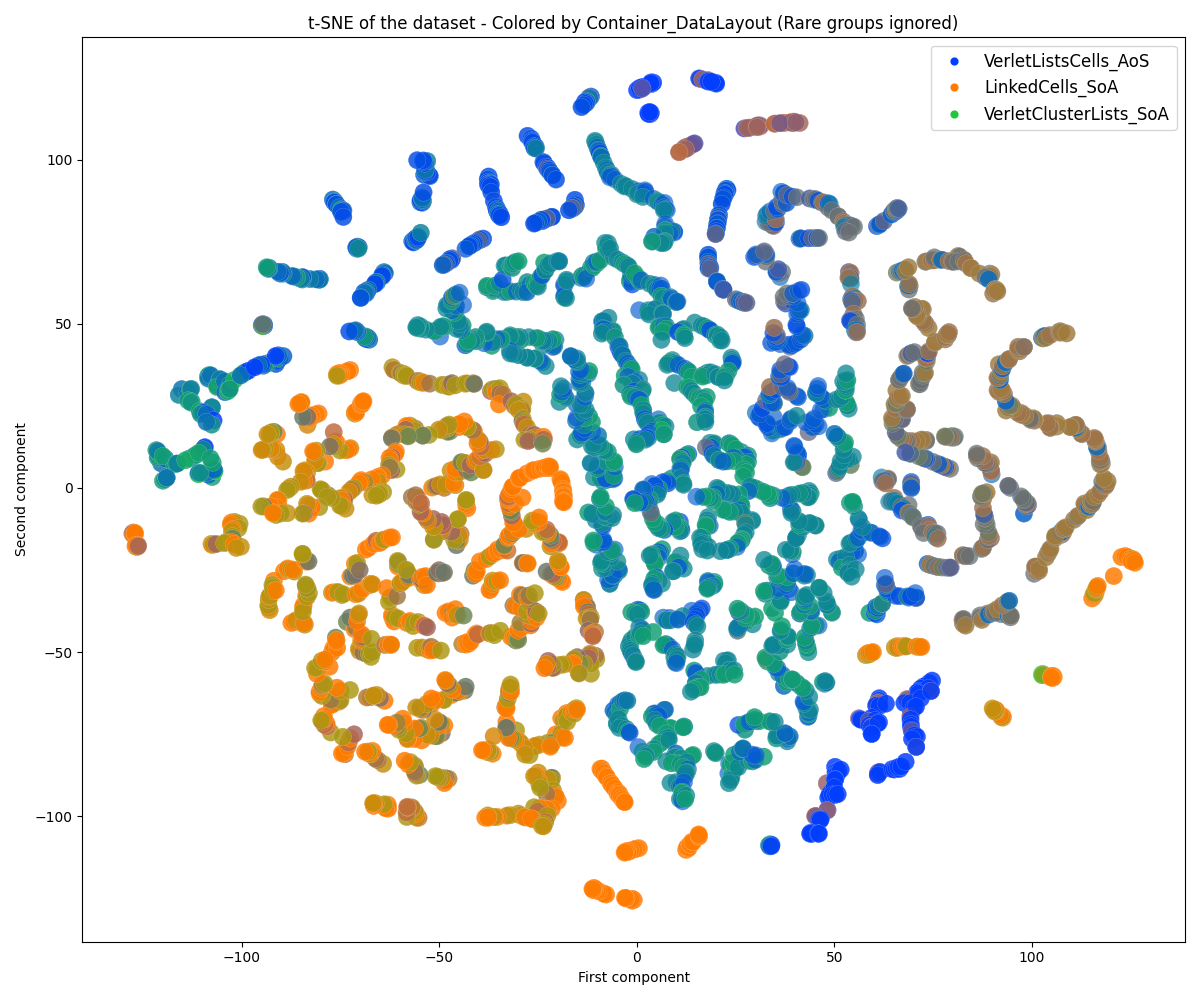

/tmp/ipykernel_98326/2178006681.py:50: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in scatter.legend_.legendHandles:


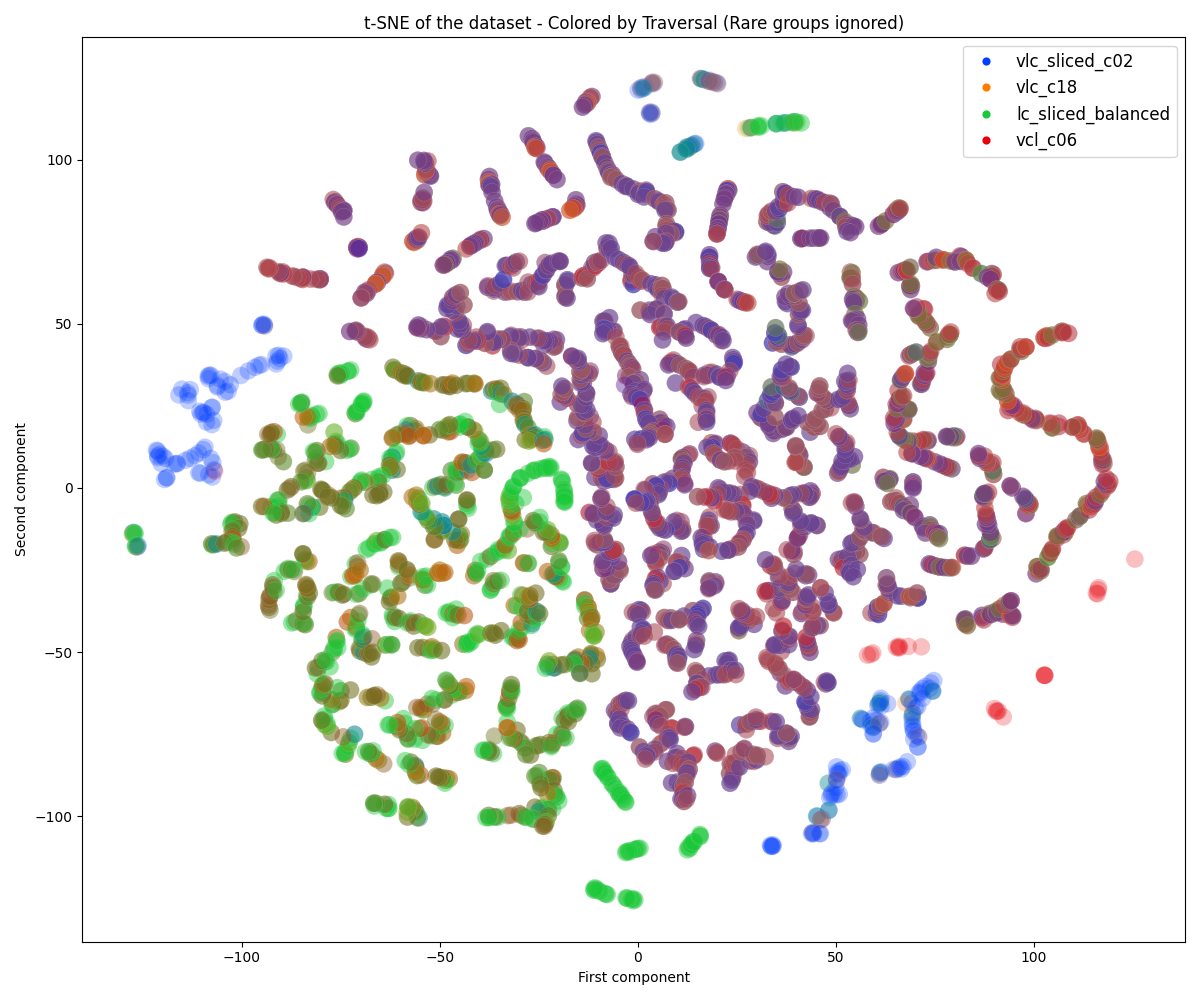

/tmp/ipykernel_98326/2178006681.py:50: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in scatter.legend_.legendHandles:


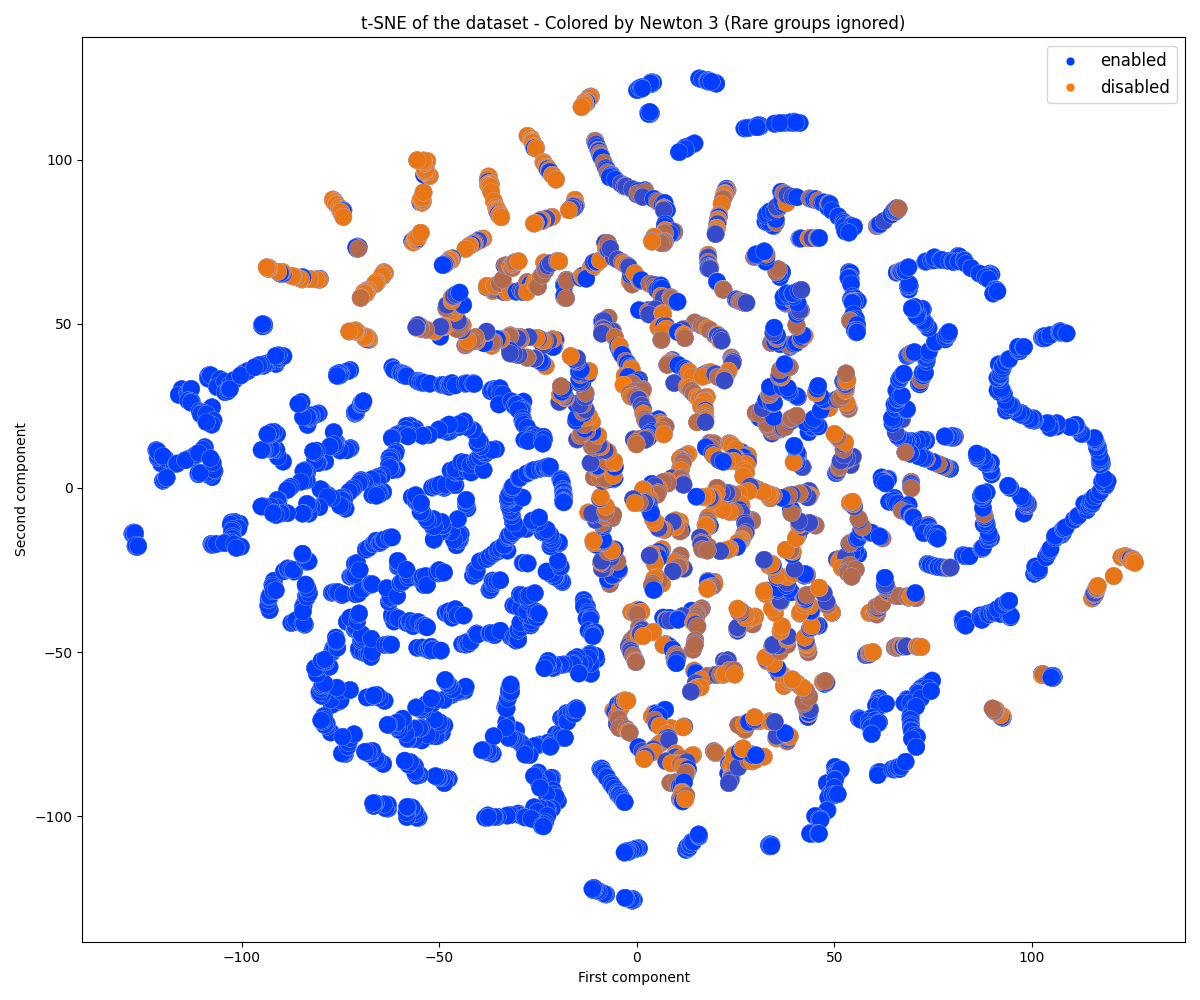

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

alpha = {
    "Container_DataLayout": 0.3,
    "Traversal": 0.25,
    "Newton 3": 0.7,
}

CUTOFF = 0.1

for output in outputs:
    # Step 4: Visualize the data
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot()

    # Filter out rare values
    value_counts = best[output].value_counts(normalize=True)
    common_values = value_counts[value_counts >= CUTOFF].index
    mask = best[output].isin(common_values)

    # Filter the data
    filtered_data = best[mask]
    filtered_components = components[mask]

    # Get unique values and colors for common groups
    unique_values = filtered_data[output].unique()
    colors = sns.color_palette("bright", len(unique_values))

    # Create a scatter plot
    scatter = sns.scatterplot(x=filtered_components[:, 0], y=filtered_components[:, 1],
                              hue=filtered_data[output], ax=ax, palette=colors,
                              linewidth=0.1, alpha=alpha[output])

    ax.collections[0].set_sizes([160])

    # Set labels and title
    ax.set_xlabel('First component')
    ax.set_ylabel('Second component')
    ax.set_title(f't-SNE of the dataset - Colored by {output} (Rare groups ignored)')

    # Adjust layout and display the plot
    plt.tight_layout()

    # Legend: make font size bigger. Don't use opacity in legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, fontsize=12)

    for lh in scatter.legend_.legendHandles:
        lh._sizes = [120]
        lh.set_alpha(1)

    plt.savefig(f"t-SNE_{output}_filtered.png")

    plt.show()

/tmp/ipykernel_98326/775538865.py:41: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in scatter.legend_.legendHandles:


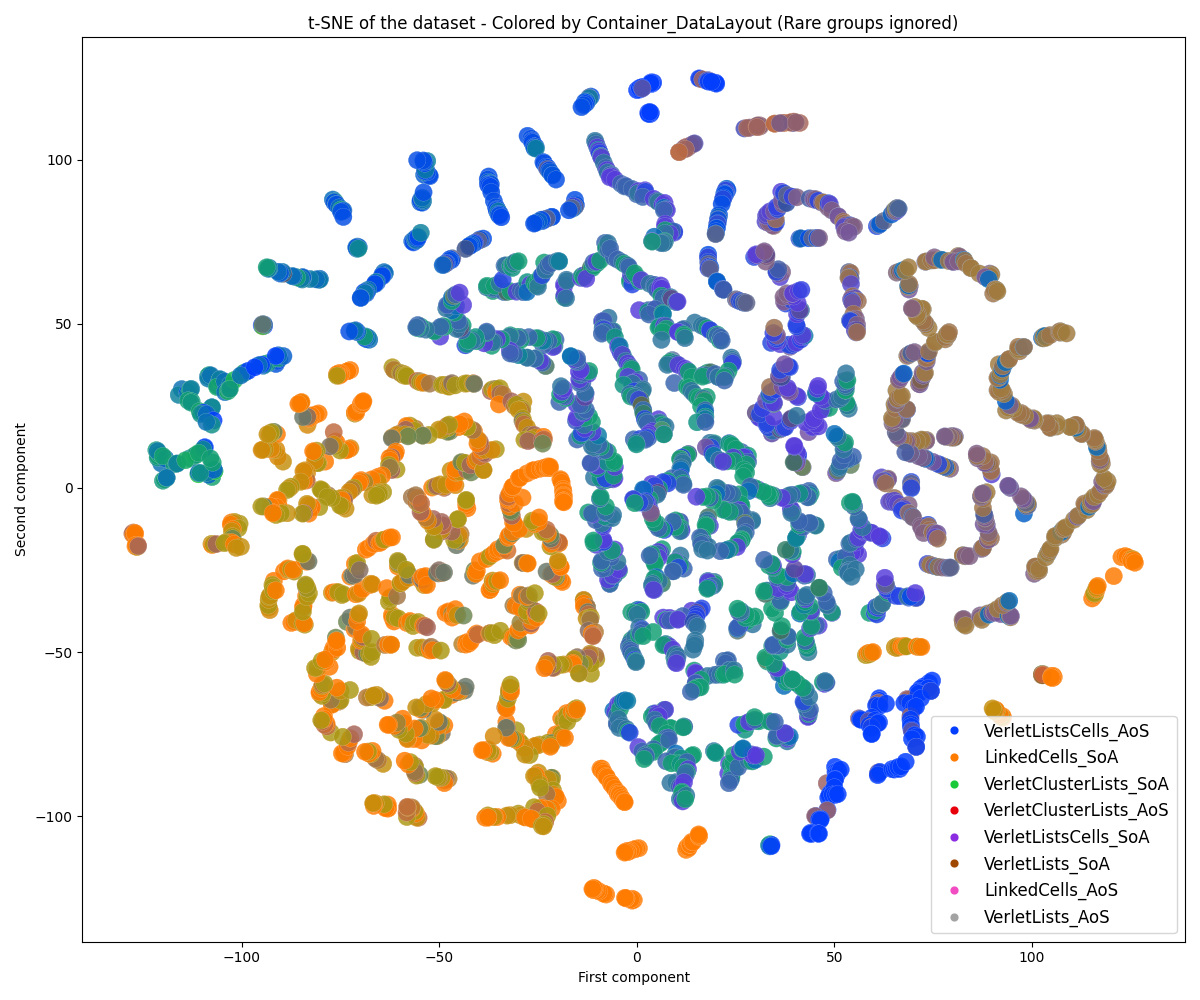

/tmp/ipykernel_98326/775538865.py:41: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in scatter.legend_.legendHandles:


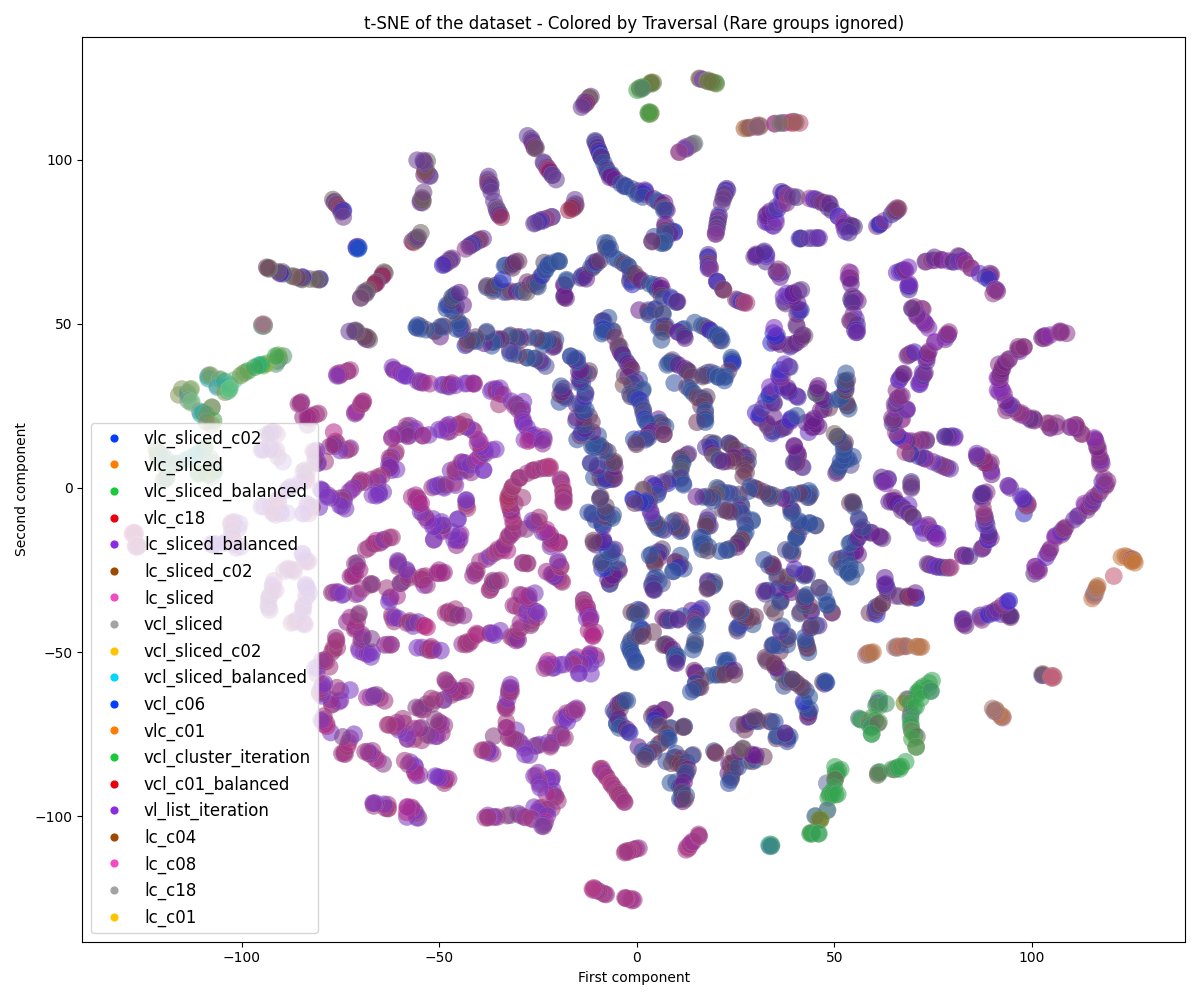

/tmp/ipykernel_98326/775538865.py:41: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in scatter.legend_.legendHandles:


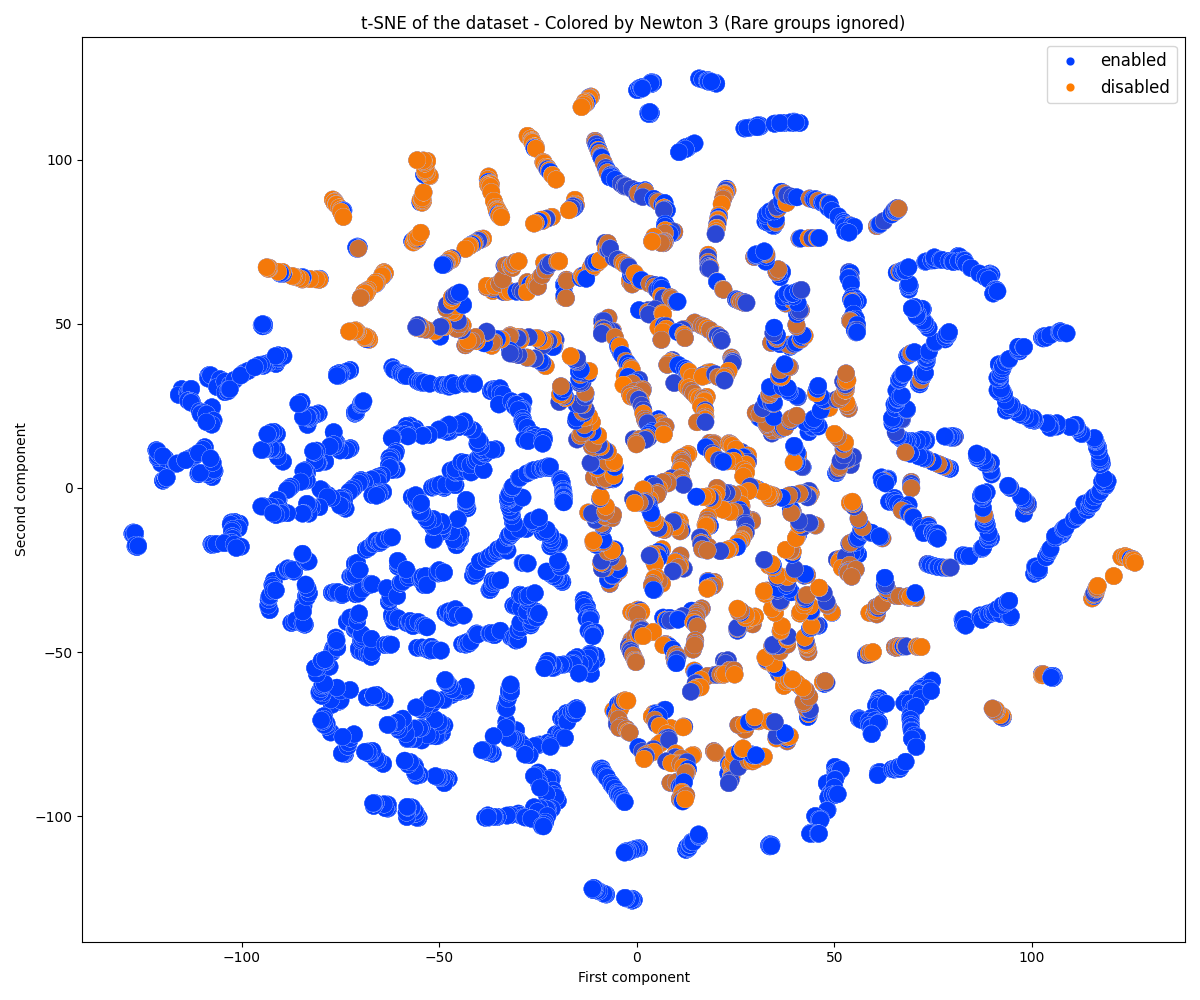

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

alpha = {
    "Container_DataLayout": 0.3,
    "Traversal": 0.15,
    "Newton 3": 0.8,
}


for output in outputs:
    # Step 4: Visualize the data
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot()

    # Get unique values and colors for common groups
    unique_values = filtered_data[output].unique()
    colors = sns.color_palette("bright", len(unique_values))

    # Create a scatter plot
    scatter = sns.scatterplot(x=components[:, 0], y=components[:, 1],
                              hue=best[output], ax=ax, palette=colors,
                              linewidth=0.1, alpha=alpha[output])

    ax.collections[0].set_sizes([160])

    # Set labels and title
    ax.set_xlabel('First component')
    ax.set_ylabel('Second component')
    ax.set_title(
        f't-SNE of the dataset - Colored by {output} (Rare groups ignored)')

    # Adjust layout and display the plot
    plt.tight_layout()

    # Legend: make font size bigger. Don't use opacity in legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, fontsize=12)

    for lh in scatter.legend_.legendHandles:
        lh._sizes = [120]
        lh.set_alpha(1)

    plt.savefig(f"t-SNE_{output}.png")

    plt.show()